## Weekly Monitoring of Field Imaging Activities

Answers Two Main Questions:</br>
* Are the Fields Collected Within Specs?
* How Are We Doing on Our 2021 Field Imaging Goals?

</br>
How Well Are We Accomplishing Our 
[2021 Data Collection Strategy(https://docs.google.com/presentation/d/1Hg890AgjU6VFeiA34EBsPYe7PdF87iHY5YvZnJMfs9s/edit?usp=sharing)]


In [5]:
# Import libraries
import os
os.environ['BRT_ENV'] = 'prod'

import time
import numpy as np
import pandas as pd
from datetime import datetime as dt
from brtdevkit.core.db import DBConnector, DatetimeFilter
from matplotlib import pyplot as plt, rcParams
from datetime import datetime
import datetime
from timezonefinder import TimezoneFinderL
import pytz
from pysolar.solar import *
from warnings import filterwarnings
filterwarnings("ignore")

tf = TimezoneFinderL()

def get_solar_angle(timestamp, latitude, longitude):
    """
    Requires datetime, TimezonefinderL, pytz and pysolar libraries
    
    Inputs: Timestamp, latitude, longitude.
    Outputs: Solar angle between (-90 , 90). Daylight conditions will always be > 0.
    """
    # Localize and adjust UTC timestamps to local timezone
    utc = pytz.utc.localize(timestamp)
    tz = tf.timezone_at(lat=latitude, lng=longitude)
    adjusted_timestamp = utc.astimezone(tz)

    # If there are invalid GPS coordinates, the function will return 'NaN'
    if adjusted_timestamp.tzinfo is not None:
        return get_altitude(latitude, longitude, adjusted_timestamp)
    else:
        return float('NaN')

def get_shasta_data(filters={}, start=None, end=None, limit=None):
    """
    Query relevant Shasta data for calculations.
    """
    start_time = time.time()
    connector = DBConnector()
    img_filters = {'project_name': 'shasta', **filters}
    if start is not None or end is not None:
        img_filters = [img_filters, DatetimeFilter(key="collected_on", start=start, end=end)]
    df = connector.get_documents_df('image', img_filters, limit=limit)
    elapsed_time = time.time() - start_time
    return df, elapsed_time

# Set filters for query
dcms_2020 = ['DCM-MANATEE', 'DCM-WALRUS', 'DCM-SEAL', 'DCM-OTTER', 'DCM-PORPOISE', 'DCM-DOLPHIN']
dcms_2021 = ['DCM11', 'DCM12', 'DCM13', 'DCM14','DCM16', 'DCM18', 'DCM19', 'DCM20', 'DCM21','DCM22','DCM23','DCM24','DCM25', 'DCM26', 'DCM27']


In [6]:
# Create DataFrame of all 2021 DCM Data
# Also calculates the solar angle, which will take a while for large DataFrames
# Set filters
filters = {'artifacts.kind': 'nrg',
        'robot_name': {'$in':dcms_2021}
          } 

# Set start and end dates for query
start = datetime.datetime(2021,3, 29) # First field was collected 3/30
end = datetime.datetime(2021, 6, 30)

full_df, elapsed_time = get_shasta_data(filters=filters, start=start, end=end)
print(f"Queried {len(full_df)} images in {elapsed_time:.2f} s.")
full_df['date_collected'] = pd.to_datetime(full_df['collected_on']).dt.date
full_df['grower_farm_field'] = full_df['grower'] +'_' + full_df['farm'] + '_' + full_df['operating_field_name']
full_df['solar_angle'] = full_df.apply(lambda x: get_solar_angle(x['collected_on'], x['latitude'], x['longitude']), axis=1)
print(f'There are {len(full_df.grower_farm_field.unique())} total fields.')

Queried 393811 images in 225.60 s.
There are 314 total fields.


### Two Ways to Look at the Data: full_df and new_fields

* full_df has all of the 2021 DCM data so far.
* new_fields has, you guessed it, just the new fields since the date entered

In [7]:
# Set minimum date to examine. Set to (2021, 3, 29) to see all fields collected in 2021

new_fields = full_df #full_df[full_df['date_collected']> datetime.datetime(2021, , 26).date()]
print(f'There are {len(new_fields.grower_farm_field.unique())} new fields.')

There are 314 new fields.


In [8]:
(new_fields.angle_to_row.value_counts()/len(new_fields))*100

PARALLEL          83.692177
ANGLED             9.551536
PERPENDICULAR      6.418053
NOT_APPLICABLE     0.330108
UNKNOWN            0.008126
Name: angle_to_row, dtype: float64

In [9]:
new_fields.groupby(['grower_farm_field', 'crop_name']).count().groupby('crop_name').count()['_id']

crop_name
CORN                      109
COTTON                    103
NONE_FALLOW_PRE_EMERGE     18
OTHER                       7
SOYBEANS                   83
Name: _id, dtype: int64

In [19]:
# Look at a Few Images To Check For Camera Problems, etc

from random import shuffle
import webbrowser

n=1
sub_df = new_fields[new_fields['grower_farm_field']==new_fields['grower_farm_field'].unique()[n]]

def show_n_images(sub_df, n):
    """
    Opens n images in new brower tabs.
    """
    if n <= 10:
        ids = sub_df['_id']
        shuffle(ids)
        for i in ids[0:n]:
            webbrowser.open_new_tab('https://aletheia.brtws.com/images/'+ str(i)) 
    else:
        print(f'{n} is maybe too many images.')
        
show_n_images(sub_df, 5)

Index(['robot_name', 'grower_farm_field', 'n_images'], dtype='object')


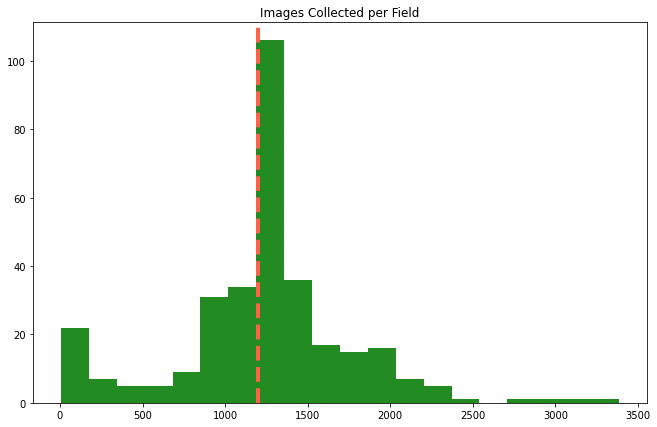

We have collected 1230.659375 images per field on average.
Of the 314 new fields, 74 fields have less than 1000 images.


In [10]:
# How many images are we collecting per field? Goal is 1200 per field

nf_size = new_fields.groupby(['robot_name','grower_farm_field']).size().reset_index()
nf_size.columns = ['robot_name', 'grower_farm_field', 'n_images']
print(nf_size.columns)

plt.figure(figsize=(11,7))
plt.hist(nf_size['n_images'], bins=20, color='forestgreen')
plt.title('Images Collected per Field')
plt.axvline(1200, color='tomato', linestyle='--', linewidth=4)
#plt.savefig('images_per_field.png')
plt.show()

print(f'We have collected {np.mean(nf_size.n_images)} images per field on average.')
print(f'Of the {len(full_df.grower_farm_field.unique())} new fields, {len(nf_size[nf_size.n_images<1000])} fields have less than 1000 images.')

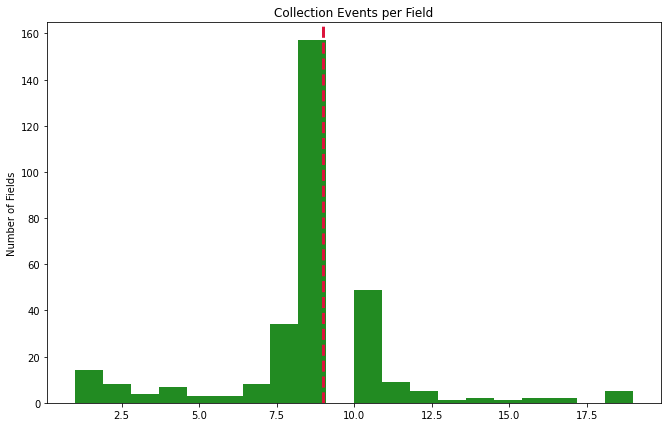

We have collected 8.630573248407643 collection events per field on average.
Of the 314 new fields, 47 fields have fewer than 8 collection events.


In [11]:
#  How Many Collection Events are we getting per field? Goal is at least 8

nf_ce = new_fields.groupby(['grower_farm_field', 'collection_id']).size().groupby('grower_farm_field').count().reset_index()
nf_ce.columns = ['grower_farm_field', 'n_collections']

plt.figure(figsize=(11,7))
plt.hist(nf_ce['n_collections'], bins=20, color='forestgreen')
plt.title('Collection Events per Field')
plt.ylabel('Number of Fields')
plt.axvline(9, color='crimson', linestyle='--', linewidth=3)
plt.show()

print(f'We have collected {np.mean(nf_ce.n_collections)} collection events per field on average.')
print(f'Of the {len(new_fields.grower_farm_field.unique())} new fields, {len(nf_ce[nf_ce.n_collections <8])} fields have fewer than 8 collection events.')

In [51]:
# How does the number of images collected per field vary by DCM?
mean_images = nf_size.groupby('robot_name').mean().reset_index()
lm = new_fields.groupby(['robot_name','grower_farm_field', 'collection_id']).size().groupby(['robot_name', 'grower_farm_field']).count().groupby('robot_name').mean().reset_index()
lm.columns = ['DCM', 'Mean Collections']
mean_images.columns = ['DCM', 'Mean Images']
dcm_stats = lm[['DCM', 'Mean Collections']].merge(mean_images)

dcm_stats

,DCM,Mean Collections,Mean Images
0,DCM12,8.434783,1249.550000
1,DCM14,7.818182,887.272727
2,DCM19,8.857143,1214.666667


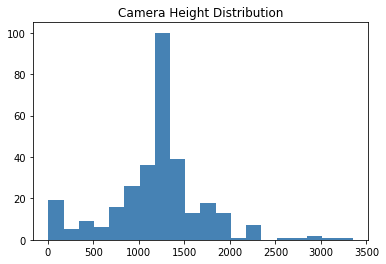

28.1% of images at the low camera height
46.6% of images at the middle camera height
25.3% of images at the high camera height


In [12]:
# Need to update this to reflect the fact that camera_heights are now continuous not discreet.

# Are the New Fields Collecting Data at Three Different Camera Heights?
# I should expand this to look at the proportion of high /mid /low

# Can play around with these cutoffs later to get the right breakdown of camera_height classes
mid = 1.8
low = 1.3

n_heights = []
pct_low = []
pct_mid = []
pct_high = []
dcm = []

for n in new_fields.grower_farm_field.unique():
    cdf = new_fields[new_fields['grower_farm_field']==n]
    dcm.append(cdf.robot_name.unique()[0])
    pct_low.append(len(cdf[cdf['camera_height']< low]) / len(cdf))
    pct_mid.append(len(cdf[(cdf['camera_height'] > low) & (cdf['camera_height']<= mid)]) / len(cdf))
    pct_high.append(len(cdf[cdf['camera_height']> mid]) / len(cdf))
    n_heights.append(len(cdf.camera_height.unique()))
    
heights = pd.DataFrame({'DCM':dcm, 'n_heights':n_heights, 'pct_low':pct_low, 'pct_mid':pct_mid, 'pct_high': pct_high})

plt.figure(figsize=(6,4))
plt.hist(heights['n_heights'], bins=20, color='steelblue')
plt.title('Camera Height Distribution')
plt.show()

# What are the proportions of high middle and low?
print(f'{(np.mean(heights.pct_low)*100):.1f}% of images at the low camera height')
print(f'{(np.mean(heights.pct_mid)*100):.1f}% of images at the middle camera height')
print(f'{(np.mean(heights.pct_high)*100):.1f}% of images at the high camera height')

In [13]:
# Are the New Fields at the Correct Proportions of Angle to Row?
wrw = ['INCHES_30', 'INCHES_36', 'INCHES_38', 'INCHES_40']
nrw = ['INCHES_LESS_THAN_7_5', 'INCHES_7_5', 'INCHES_15 in', 'INCHES_20', 'INCHES_TWIN_30', 'INCHES_TWIN_38']

gff= []
perpendicular = []
angled = []
parallel = []
dcm = []
date = []
width = []

for n in new_fields.grower_farm_field.unique():
    gff.append(n)
    cdf = new_fields[new_fields['grower_farm_field']==n]
    dcm.append(cdf.robot_name.unique()[0])
    date.append(cdf.date_collected.unique()[0])
    if cdf.row_spacing.unique()[0] in wrw:
        width.append('WIDE')
    elif cdf.row_spacing.unique()[0] in nrw:
        width.append('NARROW')
    else:
        width.append('UNKNOWN')
    parallel.append((len(cdf[cdf['angle_to_row']=='PARALLEL'])/len(cdf))*100)
    angled.append((len(cdf[cdf['angle_to_row']=='ANGLED'])/len(cdf))*100)
    perpendicular.append((len(cdf[cdf['angle_to_row']=='PERPENDICULAR'])/len(cdf))*100)
    
angles = pd.DataFrame({'GFF':gff, 'DCM': dcm, 'Date': date, 'Width': width, 'pct_PAR':parallel, 'pct_ANG':angled, 'pct_PERP': perpendicular})
# The angles DF should now tell me the proportion of angles for every new field.
angles[0:10]

,GFF,DCM,Date,Width,pct_PAR,pct_ANG,pct_PERP
0,Allen Below_Section 20_9&10,DCM14,2021-05-06,WIDE,89.244663,10.755337,0.0
1,Allen Below_Section 20_1&2,DCM14,2021-05-06,WIDE,77.723178,22.276822,0.0
2,Allen Below_Section 20_5,DCM14,2021-05-06,WIDE,89.239482,10.760518,0.0
3,Andew Miller_Andrew Miller Farms_Sandridge 370...,DCM12,2021-05-06,UNKNOWN,100.000000,0.000000,0.0
4,Andrew Miller_Andrew Miller Farms_Espejo South...,DCM12,2021-05-06,UNKNOWN,100.000000,0.000000,0.0
5,Andrew Miller_Andrew Miller Farms_Steele East ...,DCM12,2021-05-06,UNKNOWN,100.000000,0.000000,0.0
6,Beakley_flynt_fm55,DCM12,2021-04-28,WIDE,89.130435,10.869565,0.0
7,Blake Lauritsen_422Co&1162FM_422Co&1162FM,DCM13,2021-04-19,WIDE,94.320594,5.679406,0.0
8,"Blake Lauritsen_FM1162 & 422CO_curve1162FM,422",DCM13,2021-04-19,WIDE,92.763158,7.236842,0.0
9,Blake Lauritsen_FM1162 & 442CO_FM1162&442CO,DCM13,2021-04-19,WIDE,92.099792,7.900208,0.0


In [14]:
from geopy import distance
new_fields = full_df
#new_fields = new_fields[new_fields['robot_name']=='DCM13']

field_names = []
img_per_m = []
min_length = []
mean_length = []
max_length = []
n_collections = []
total_length = []
images = []
times = []
dcms = []
walking_speeds = []

for fn in new_fields.grower_farm_field.unique():
    field = new_fields[new_fields['grower_farm_field']==fn].sort_values(by='collected_on')
    dcms.append(field.robot_name.unique()[0])
    collections = []
    for cid in field.collection_id.unique():
        collection_info = field[field['collection_id']==cid]
        collection_info = collection_info.sort_values(by='collected_on')
        n = len(collection_info)
        first_lat_long = [collection_info.latitude[0], collection_info.longitude[0]]
        last_lat_long = [collection_info.latitude[n-1], collection_info.longitude[n-1]]
        collections.append(distance.distance(first_lat_long, last_lat_long).meters)
    field_names.append(fn)
    min_length.append(np.min(collections))
    max_length.append(np.max(collections))
    mean_length.append(np.median(collections))
    total_length.append(np.sum(collections))
    n_collections.append(len(collections))
    images.append(len(field))
    img_per_m.append(len(field)/np.sum(collections))
    total_time = field['collected_on'][0]
    for n in range(1,len(field)-1):
            first_time = field['collected_on'][n]
            last_time = field['collected_on'][n+1]
            timespan = (last_time - first_time)
            if (timespan.seconds < 220) and (timespan.seconds > 0):
                total_time = total_time + (timespan)
    times.append((total_time - field['collected_on'][0]).total_seconds()/60)
    walking_speeds.append(np.sum(collections)/(total_time - field['collected_on'][0]).total_seconds())

collection_lengths = pd.DataFrame({'Field Name': field_names, 'Collections': n_collections, 
                                   'Total Images': images, 'Images / m': img_per_m,
                                   'Total Length': total_length,'Min Length': min_length, 
                                   'Max Length':max_length, 'Median Length': mean_length,
                                   'Time Spent (min)': times, 'Walking Speed': walking_speeds, 'DCM': dcms
                                   })
#collection_lengths = collection_lengths.drop([42, 52, 53, 54]) # remove tests
collection_lengths[0:5]

,Field Name,Collections,Total Images,Images / m,Total Length,Min Length,Max Length,Median Length,Time Spent (min),Walking Speed,DCM
0,Allen Below_Section 20_9&10,9,1218,1.584455,768.718554,77.041866,89.993666,85.901503,7.458333,1.717807,DCM14
1,Allen Below_Section 20_1&2,9,1221,1.568643,778.379731,80.417517,91.349195,87.255351,5.466667,2.373109,DCM14
2,Allen Below_Section 20_5,9,1236,1.543482,800.786760,84.167005,93.854930,88.900915,5.083333,2.625530,DCM14
3,Andew Miller_Andrew Miller Farms_Sandridge 370...,1,162,2.043452,79.277624,79.277624,79.277624,79.277624,0.000000,inf,DCM12
4,Andrew Miller_Andrew Miller Farms_Espejo South...,9,1389,2.025908,685.618632,47.645782,85.562649,78.809460,13.208333,0.865134,DCM12


In [15]:
print(collection_lengths['Total Images'].sum() / collection_lengths['Total Length'].sum())

print(np.median(collection_lengths['Median Length'][0:10]))
print((collection_lengths['Total Images'][0:10]).sum()/12)

2.005582765717364
80.2925842485007
1127.3333333333333


In [26]:
means = collection_lengths.groupby('DCM').median()
means.columns = ['Median Num Collections', 'Median Num Images per Field', 'Images / m', 'Total Length',
       'Min Length', 'Max Length', 'Median Length (m)', 'Time Spent Collecting (minutes)',
       'Walking Speed m/s']
means[['Median Num Collections', 'Median Num Images per Field','Median Length (m)', 'Time Spent Collecting (minutes)']]

,Median Num Collections,Median Num Images per Field,Median Length (m),Time Spent Collecting (minutes)
DCM,,,,
DCM11,9.0,1467.5,82.868670,9.550000
DCM12,9.0,1313.0,81.655973,10.962500
DCM13,9.0,1876.5,81.574937,6.135492
DCM14,9.0,1145.0,81.540551,7.583333
DCM16,9.0,1311.5,65.363040,7.895833
DCM18,9.0,1237.5,63.886567,12.680250
DCM19,9.0,1234.0,73.458509,9.841667
DCM20,9.0,1301.0,70.574987,9.833333
DCM22,7.0,955.5,78.403777,8.370858


In [17]:
# Are the Collections enough Distance? (Not Sure If I'll Need This)
# Create dataframe of distance covered and number of images collected per field
# Vectorizing these calculations would get rid of these for loops and make this cell run a bit faster

# UPDATE THIS FOR COLECTION RUN
new_fields = full_df
from geopy import distance

ds = []
time = []
ns = []
cms= []
fields = []
total_times = []
dcms = new_fields.groupby(['grower_farm_field','robot_name']).count().reset_index()
dc = dcms['robot_name'].unique()

for d in dc:
    ddf = new_fields[new_fields['robot_name']==d]
    for o in ddf['operating_field_name'].unique():
        op = ddf[ddf['operating_field_name']== o]
        times = op['collected_on']
        dst = 0
        ft = op['collected_on'][0]
        total_time = ft
        for n in range(1,len(op)-1):
            first_lat_long = [op.latitude[n-1], op.longitude[n-1]]
            last_lat_long = [op.latitude[n], op.longitude[n]]
            dist_travelled = distance.distance(first_lat_long, last_lat_long).meters
            if (dist_travelled < 2) and (dist_travelled > 0):
                dst+=(dist_travelled)
        for n in range(1,len(op)-1):
            first_time = times[n]
            last_time = times[n+1]
            timespan = (last_time - first_time)
            if (timespan.seconds < 5) and (timespan.seconds > 0):
                total_time = total_time + (timespan)
        ds.append(dst)
        fields.append(o)
        cms.append(d)
        ns.append(len(op))
        total_times.append((total_time - ft).total_seconds())

dcm_distances = pd.DataFrame({'dcm_name':cms, 'operating_field_name':fields, 'n_images_collected':ns, 'distance_covered (m)':ds, 'time_spent_collecting (s)':total_times})
dcm_distances[0:10]

,dcm_name,operating_field_name,n_images_collected,distance_covered (m),time_spent_collecting (s)
0,DCM12,Sandridge 3700-J/0370010,162,84.806484,0.0
1,DCM12,Espejo South 3883-B,1389,733.078204,2.0
2,DCM12,Steele East 3567/Steele 1,1290,707.739587,1.0
3,DCM12,fm55,1380,808.244923,3.0
4,DCM12,482 (SW Corner),1336,719.280480,4.0
5,DCM12,482 (SW),1366,718.536327,2.0
6,DCM12,Creek Field,1355,1505.967162,10.0
7,DCM12,"28.9250744, -96.4763700",1447,804.285623,3.0
8,DCM12,"28.894, -96.393",1422,790.875039,0.0
9,DCM12,Johnson 1,1507,878.984327,2.0


### Stats for the Full Season

Using the full_df DataFrame


There have been 269481 images collected.
There are 207 total fields collected so far this season.


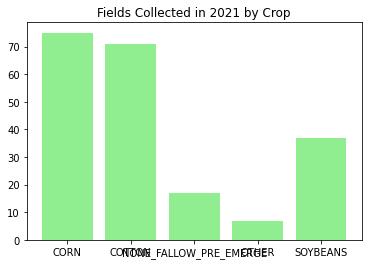

In [18]:
# How Many fields Have Been Collected To Date?

all_fields = full_df.groupby(['grower_farm_field', 'crop_name']).count()['_id'].reset_index()
all_fields.columns = ['grower_farm_field', 'crop_name','n_images']

print(f'There have been {all_fields.n_images.sum()} images collected.')
print(f'There are {len(all_fields)} total fields collected so far this season.')

crops = all_fields.groupby('crop_name').count()['n_images']

plt.bar(crops.index, crops, color = 'lightgreen')
plt.title('Fields Collected in 2021 by Crop')
plt.show()

In [17]:
# Examine Fields in a Map
import folium

field_locs = full_df.groupby('grower_farm_field').median().reset_index()[['grower_farm_field','latitude', 'longitude']]

# Generate base_map for adding points
def generateBaseMap(default_location=[36, -100], default_zoom_start=4.25):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
base_map = generateBaseMap()

# Add growers to the base_map
for i in range(len(field_locs)):
    folium.Marker(location=[field_locs.latitude[i], field_locs.longitude[i]],popup= field_locs.grower_farm_field[i]).add_to(base_map)

base_map

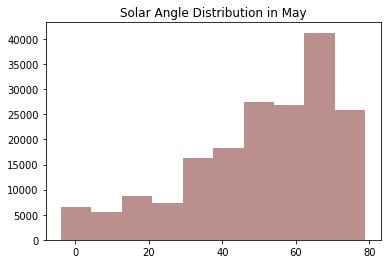

In [21]:
#What is the distribution of solar angles?
solar_angles = full_df[full_df['date_collected']>datetime.datetime(2021, 4, 30).date()]['solar_angle']
#plt.figure(figsize=(10,7))
plt.hist(solar_angles, color = 'rosybrown')
plt.title('Solar Angle Distribution in May')
plt.savefig('solar_angle.png', dpi=100)
plt.show()

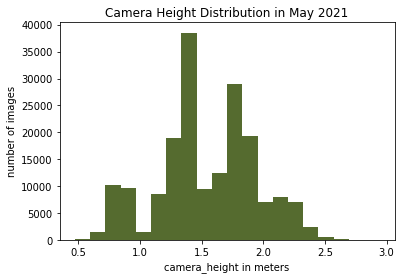

In [22]:
#What is the distribution of solar angles?
camera_heights = full_df[full_df['date_collected']>datetime.datetime(2021, 4, 30).date()]['camera_height']
plt.hist(camera_heights, color = 'darkolivegreen', bins=20)
plt.title('Camera Height Distribution in May 2021')
plt.ylabel('number of images')
plt.xlabel('camera_height in meters')
plt.savefig('camera_heights.png')
plt.show()

In [22]:
ang = full_df[full_df['date_collected']>datetime.datetime(2021, 4, 2).date()]['angle_to_row'].value_counts()
pcts = ang/np.sum(ang)
pcts

PARALLEL          0.868892
ANGLED            0.080296
PERPENDICULAR     0.046949
NOT_APPLICABLE    0.003793
UNKNOWN           0.000071
Name: angle_to_row, dtype: float64

In [29]:
low = full_df[full_df['solar_angle']<=15]
print(len(low))
print(f'There are {len(low.operating_field_name.unique())} low solar angle fields (<=15 degrees)')

real_low = full_df[full_df['solar_angle']<=5]
print(len(real_low))
print(f'There are {len(real_low.operating_field_name.unique())} extremely low solar angle fields (<=5 degrees)')

12625
There are 12 low solar angle fields (<=15 degrees)
5040
There are 5 extremely low solar angle fields (<=5 degrees)


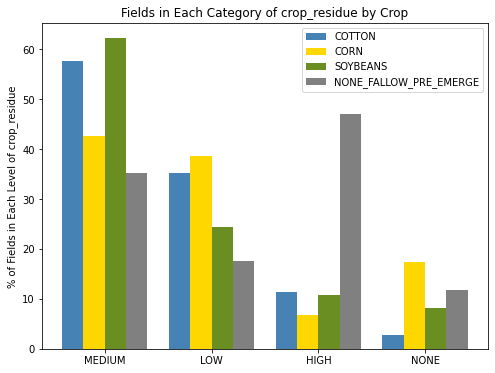

crop_residue,MEDIUM,LOW,HIGH,NONE
COTTON,57.7,35.2,11.3,2.8
CORN,42.7,38.7,6.7,17.3
SOYBEANS,62.2,24.3,10.8,8.1
NONE_FALLOW_PRE_EMERGE,35.3,17.6,47.1,11.8


In [34]:
# How is the distribution of the different metadata fields and how do they vary by crop?

def metadata_table(df, p):
    """
    Creates a table showing the number of fields in each category of metadata by crop.
    p must be a categorical metadata field that is a string or number, not a list.
    """
    cats = pd.Series(df[p].unique())
    for n in df.crop_name.unique():
        s = pd.Series([ np.round((len(df[(df.crop_name==n) & (df[p] == i)].grower_farm_field.unique())/len(df[(df.crop_name==n)].grower_farm_field.unique()))*100, 1) for i in df[p].unique()])
        cats = pd.concat([cats, s], axis = 1)
    cats.columns = [p] + list(df.crop_name.unique())
    cats = cats.transpose()
    cats.columns = cats.iloc[0]
    cats.drop(p, axis=0, inplace=True)
    return cats

def plot_metadata(df, p, figsize=(8,6)):
    """
    Creates a barplot of the number of fields in each category of the metadata field p.
    """
    colors = {'WHEAT':'wheat', 'COTTON': 'steelblue', 'CORN': 'gold', 'SOYBEANS': 'olivedrab', 'NONE_FALLOW_PRE_EMERGE': 'grey'}
    m = metadata_table(df, p)
    n = len(m.iloc[0])
    ind = (np.arange(n))  
    width = 0.2       # the width of the bars
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    for i in range(len(m)):
        ax.bar(ind, m.iloc[i], width, color=colors[m.index[i]])
        ind = [n + width for n in ind]
    ax.set_xticks([ i + 0.3 for i in range(n)] )
    ax.set_xticklabels(m.columns)
    plt.legend(m.index)
    plt.ylabel('% of Fields in Each Level of ' +p)
    plt.title('Fields in Each Category of ' + p + ' by Crop')
    plt.show()   
    return m

plot_metadata(full_df[full_df['crop_name']!='OTHER'], 'crop_residue')

In [28]:
# How much of our data, by crop, is within the MY23 spec (by row_spacing at least)
in_spec_rs = ["INCHES_30",  "INCHES_36", "INCHES_38", "INCHES_40"]
out_spec_rs = ["INCHES_7_5", "INCHES_15", "INCHES_20", "INCHES_TWIN_30", "INCHES_TWIN_38", "SKIP_ROW"]
undefined_spec_rs = ["CENTIMETERS_12_5", "CENTIMETERS_15", "CENTIMETERS_16_5", "CENTIMETERS_45", "CENTIMETERS_50", "CENTIMETERS_75", "OTHER"]

rs = full_df.groupby(['grower_farm_field', 'crop_name','row_spacing']).count().reset_index()

specs = []
rss = []
crops = []

pos = [in_spec_rs, out_spec_rs, undefined_spec_rs]   
pos_labels = ['in_spec', 'out_of_spec', 'unknown']
for c in full_df.crop_name.unique():
    for p in range(len(pos)):
        crops.append(c)
        rss.append(pos_labels[p])
        specs.append(len(rs[(rs['row_spacing'].isin(pos[p])) & (rs['crop_name']==c)]))
        
#specs = [len(rs[rs['row_spacing'].isin(in_spec_rs)& rs['crop_name']==c]), len(rs[rs['row_spacing'].isin(out_spec_rs)]), len(rs[rs['row_spacing'].isin(undefined_spec_rs)])]
spec_fields = pd.DataFrame({'crop': crops, 'rs':rss,'n_fields':specs})

colors = {'WHEAT':'wheat', 'COTTON': 'steelblue', 'CORN': 'gold', 'SOYBEANS': 'olivedrab'}
print(spec_fields)
 
# TODO: Make a plot of this data

                      crop           rs  n_fields
0                   COTTON      in_spec        67
1                   COTTON  out_of_spec         4
2                   COTTON      unknown         0
3                     CORN      in_spec        71
4                     CORN  out_of_spec         4
5                     CORN      unknown         0
6                 SOYBEANS      in_spec        25
7                 SOYBEANS  out_of_spec        13
8                 SOYBEANS      unknown         0
9   NONE_FALLOW_PRE_EMERGE      in_spec         0
10  NONE_FALLOW_PRE_EMERGE  out_of_spec         0
11  NONE_FALLOW_PRE_EMERGE      unknown         0
12                   OTHER      in_spec         2
13                   OTHER  out_of_spec         0
14                   OTHER      unknown         4


KeyError: 'NONE_FALLOW_PRE_EMERGE'

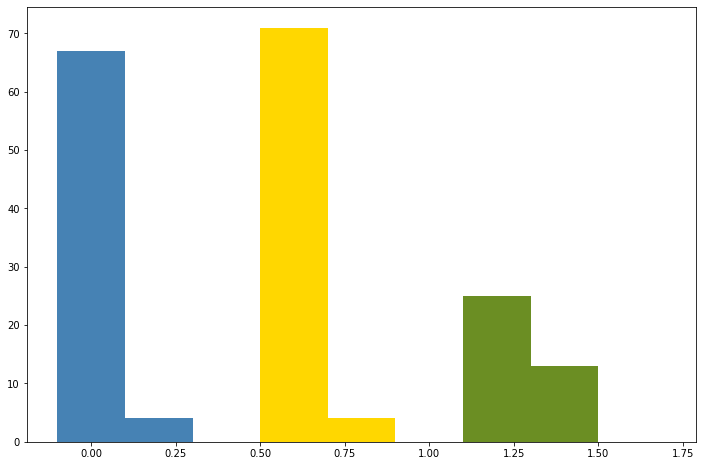

In [36]:
# Graph of Above (In-progress)

ind = (np.arange(len(spec_fields))*0.2)  
width = 0.2       # the width of the bars
plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

# Format Legend
import matplotlib.patches as mpatches
legend_colors = [mpatches.Patch(color='wheat', label='WHEAT'), 
                 mpatches.Patch(color='steelblue', label='COTTON'),
                 mpatches.Patch(color='gold', label='CORN'),
                 mpatches.Patch(color='olivedrab', label='SOYBEANS'),
                 mpatches.Patch(color='grey', label='NONE_FALLOW_PRE_EMERGE'),
                 mpatches.Patch(color='magenta', label='OTHER')
                ]

for i in range(len(spec_fields)):
    ax.bar(ind[i], spec_fields.iloc[i]['n_fields'], width=width, color=colors[spec_fields.crop[i]])
ax.set_xticks(range(3))
ax.set_xticklabels(spec_fields.rs.unique())
plt.legend(handles=legend_colors)
plt.ylabel('Number of Fields in Each Spec Group')
plt.title('In- and Out- of MY23 Spec Fields by Crop')
plt.show()  

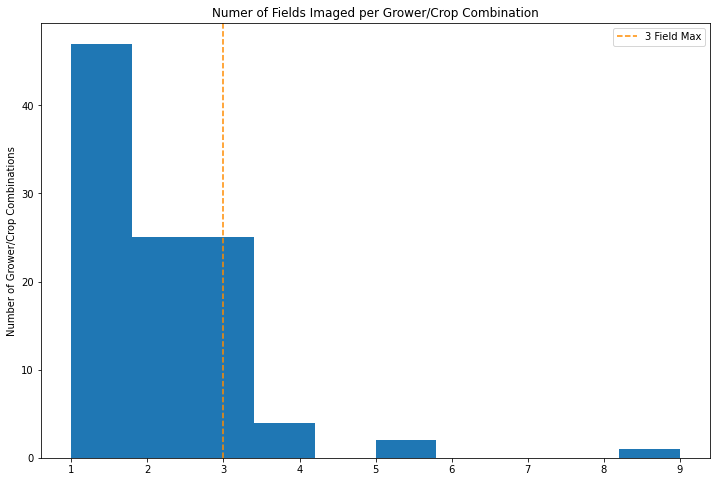

Out of 104 grower/crop combinations, there were 7 or 6.7% with more than 3 fields listed.


In [37]:
# Are we collecting too many fields per grower per crop (>3 fields)? (Demo fields excluded from this)
fcg_combos = full_df.groupby(['grower', 'grower_farm_field','crop_name']).count().reset_index()
counts = fcg_combos.groupby(['grower', 'crop_name']).count().reset_index()[['grower','crop_name', '_id']]
counts.columns = ['grower', 'crop_name', 'n_fields']

plt.figure(figsize=(12,8))
plt.hist(counts['n_fields'])
plt.title('Numer of Fields Imaged per Grower/Crop Combination')
plt.axvline(3, color='darkorange', linestyle='--')
#plt.xlim(0.5,15.5)
plt.ylabel('Number of Grower/Crop Combinations')
plt.legend(['3 Field Max'])
plt.show()

over = counts[counts['n_fields']>3]
print(f'Out of {len(counts)} grower/crop combinations, there were {len(over)} or {(len(over)/len(counts))*100:.1f}% with more than 3 fields listed.')

In [27]:
# Are we collecting enough fields with different crop_health conditions?

crops = ['CORN','SOYBEANS','COTTON', 'WHEAT']
field_health = full_df.groupby(['crop_name','grower_farm_field','crop_health']).count().reset_index()
chs = field_health['crop_health'].unique()
crop_health = pd.Series(chs, name='Crop Health')

for c in crops:
    he = field_health[field_health['crop_name']==c]
    hl = []
    for h in chs:
        nh = he[he['crop_health'] == h]
        hl.append(len(nh))
    hlt = pd.Series(hl, name=(c[0] + c[1:].lower()+' Fields'))
    crop_health = pd.concat([crop_health, hlt], axis=1)

crop_health

,Crop Health,Corn Fields,Soybeans Fields,Cotton Fields,Wheat Fields
0,HEALTHY,74,30,45,0
1,STRESSED,1,7,28,0
2,NOT_APPLICABLE,0,0,0,0
3,UNKNOWN,0,0,0,0


In [26]:
# Should we aim to collect more data on damaged or unhealthy crops? 
from sklearn.preprocessing import MultiLabelBinarizer

# One-hot encoding each unique crop_damage
s = full_df['crop_damage']
mlb = MultiLabelBinarizer()
w = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=full_df.index)
l = full_df[['grower_farm_field','crop_name']]
damage_df = pd.merge(w, l, left_index=True, right_index=True)

damaged_fields = damage_df.groupby(['crop_name','grower_farm_field']).sum()
damaged_fields = damaged_fields[damaged_fields['NONE']==0].reset_index()

# Count Fields with Crop Damage
# , 'OTHER', 'CUPPING','TATTERING','WILTING',
damages = [  'SPOTTING',  'YELLOWING']
dmg = pd.Series(damages, name='Damage Type')
master=pd.Series(damages, name = 'crop_damage')
crops = damaged_fields.crop_name.unique()

for c in crops:
    dfs = damaged_fields[damaged_fields['crop_name']==c]
    ds = []
    for d in damages:
        ds.append(len(dfs[dfs[d]>0]))
    ds = pd.Series(ds, name=(c[0] + c[1:].lower()+' Fields'))
    dmg = pd.concat([dmg, ds], axis=1)
    
dmg

,Damage Type,Corn Fields,Cotton Fields,None_fallow_pre_emerge Fields,Soybeans Fields
0,SPOTTING,0,17,0,1
1,YELLOWING,4,10,0,3
